# **MMED GROUP 3 : DRAFT**

# **Section 1: Maximum Likelihood Estimate**

In [ ]:
# Remove all objects in memory
rm(list = ls())

**1.  LOAD NECESSARY LIBRARIES**

In [ ]:
install.packages("deSolve")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages("MCMCpack")
#install.packages("adaptMCMC")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘SparseM’, ‘MatrixModels’, ‘coda’, ‘mcmc’, ‘quantreg’




In [ ]:
install.packages("ellipse")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages("mnormt")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages("emdbook")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘numDeriv’, ‘bdsmatrix’, ‘mvtnorm’, ‘plyr’, ‘bbmle’




In [ ]:
library(deSolve)
library(MCMCpack)
library(coda)
library(ggplot2)
library(boot)
library(ellipse)
library(parallel)
library(mnormt)
library(emdbook)

Loading required package: coda

Loading required package: MASS

##
## Markov Chain Monte Carlo Package (MCMCpack)

## Copyright (C) 2003-2024 Andrew D. Martin, Kevin M. Quinn, and Jong Hee Park

##
## Support provided by the U.S. National Science Foundation

## (Grants SES-0350646 and SES-0350613)
##


Attaching package: ‘ellipse’


The following object is masked from ‘package:graphics’:

    pairs




**2. MODEL IMPLEMENTATION**

In epidemiological models, a control function $C(t)$ is often used to simulate the impact of *interventions, policies, or behavioral changes* over time that affect the transmission dynamics of the disease. The form of $C(t)$ can vary depending on the specific model and the nature of the intervention being simulated. Common forms include `step functions` (representing sudden changes), `logistic functions` (representing gradual changes), or other functional forms that model the timing and effectiveness of interventions. So, in the cell below we are gonna implement the $SI_{1:4}$ model including interventions.

In [ ]:
# Function to set disease parameters with default values
disease_params <- function(lambda = 0.9, a = 5.5, cMax = 0.85, cRate = 1, cHalf = 1990,
                           delta = 0.1, b = 0.02, mu = 0.01) {
  return(as.list(environment()))
}

In [ ]:
# Define the SI_1_4 ODE model
SImod <- function(tt, yy, parms) with(as.list(c(parms, yy)), {
  I <- I1 + I2 + I3 + I4  # Total infected
  N <- S + I  # Total population
  lambdaHat <- lambda * exp(-a * I / N)  # Effective transmission rate
  C_t <- 1 - cMax / (1 + exp(-cRate * (tt - cHalf)))  # Control function C(t)
 #invControl <- min(1,1 - cMax/(1+exp(-cRate*(t-cHalf))))
  FOI <- lambdaHat * I / N * C_t  # Force of infection
  g <- 4 * delta  # Transition rate between stages

  deriv <- rep(NA, 7)
  deriv[1] <- b * N - FOI * S - mu * S  # Susceptibles
  deriv[2] <- FOI * S - g * I1 - mu * I1  # Infection class I1
  deriv[3] <- g * I1 - g * I2 - mu * I2  # Infection class I2
  deriv[4] <- g * I2 - g * I3 - mu * I3  # Infection class I3
  deriv[5] <- g * I3 - g * I4 - mu * I4  # Infection class I4
  deriv[6] <- FOI * S  # Cumulative incidence
  deriv[7] <- g * I4  # Cumulative mortality
  return(list(deriv))
})



In this model, the control function $C(t)$ is defined by the logistic function:
$$C(t) = 1 - \frac{c_{\text{Max}}}{1 + \exp(-c_{\text{Rate}} \cdot (t - c_{\text{Half}}))}$$
where:

- $ c_{\text{Max}}$ represents the maximum effect of the control function.

- $ c_{\text{Rate}}$ is the rate parameter determining how quickly the control function changes over time.

- $ c_{\text{Half}} $ denotes the time at which the control function achieves half of its maximum effect.

In [ ]:
# Function to run the deterministic model simulation
simEpidemic <- function(init, tseq, modFunction, parms) {
  simDat <- as.data.frame(ode(y = init, times = tseq, func = modFunction, parms = parms))
  simDat$I <- rowSums(simDat[, paste0("I", 1:4)])
  simDat$N <- rowSums(simDat[, c("S", paste0("I", 1:4))])
  simDat$P <- simDat$I / simDat$N
  return(simDat)
}

In [ ]:
# Initial conditions and time sequence
init <- c(S = 999, I1 = 5, I2 = 3, I3 = 1, I4 = 1, CI = 0, CD = 0)
tseqAnnual <- seq(1980, 2020, by = 1)

# Simulate the epidemic with default parameters
trueParms <- disease_params()
simDat <- simEpidemic(init, tseq = tseqAnnual, modFunction = SImod, parms = trueParms)

In [ ]:
# Visualize dataframe
head(simDat)

,time,S,I1,I2,I3,I4,CI,CD,I,N,P
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1980,999.0000,5.00000,3.000000,1.000000,1.000000,0.00000,0.0000000,10.00000,1009.000,0.009910803
2,1981,996.9517,13.68171,5.014798,1.929171,1.142893,12.33872,0.4183274,21.76857,1018.720,0.021368544
3,1982,984.2382,28.53410,10.230372,3.735847,1.671330,35.60710,0.9644457,44.17165,1028.410,0.042951405
4,1983,958.2416,49.61311,19.718175,7.374367,2.909609,72.54383,1.8491177,79.61526,1037.857,0.076711212
5,1984,921.7897,72.43473,33.407790,13.667300,5.374266,120.43623,3.4555951,124.88408,1046.674,0.119315192
6,1985,881.4485,91.03854,49.377274,22.807848,9.581160,172.77270,6.3820737,172.80482,1054.253,0.163912056


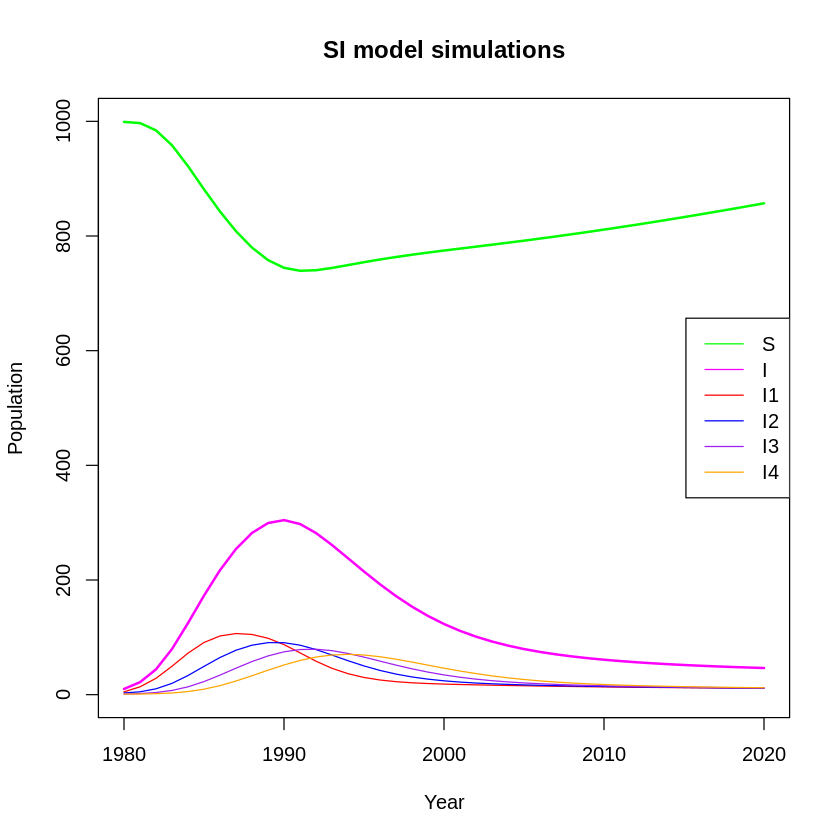

In [ ]:
# Plot compartments
plot(simDat$time, simDat$S, type = "l", col = "green", xlab = "Year",ylim=c(0,1000), ylab = "Population",lwd=2,
     main = "SI model simulations")
lines(simDat$time, simDat$I, col = "magenta",lwd = 2)
lines(simDat$time, simDat$I1, col = "red")
lines(simDat$time, simDat$I2, col = "blue")
lines(simDat$time, simDat$I3, col = "purple")
lines(simDat$time, simDat$I4, col = "orange")
legend("right", legend = c("S","I", "I1", "I2", "I3", "I4"), col = c("green","magenta", "red", "blue", "purple", "orange"), lty = 1)

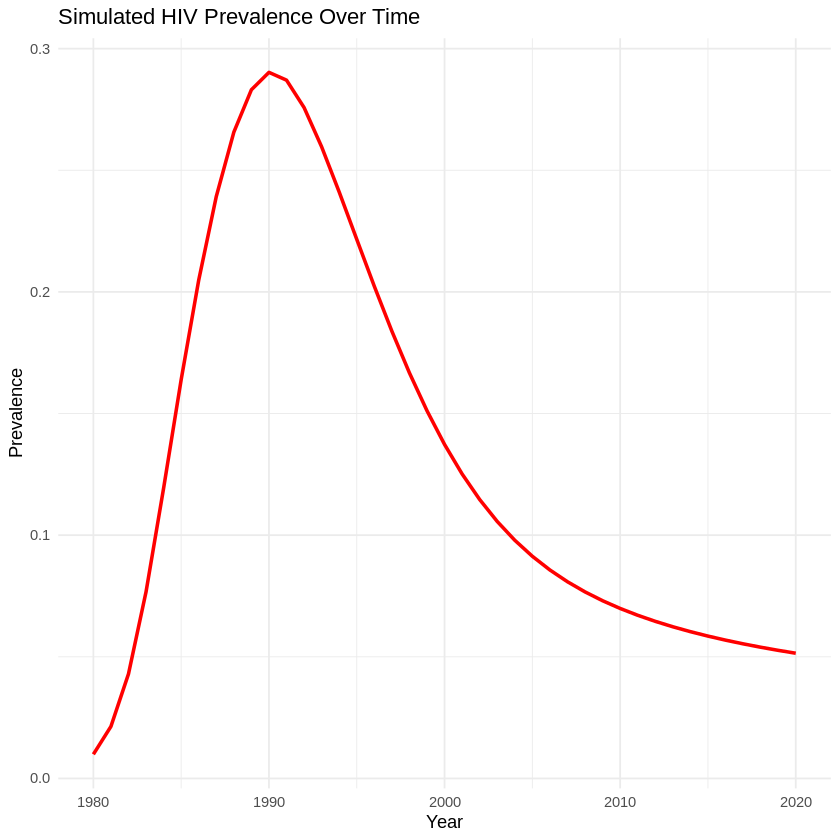

In [ ]:
# Plot simulated prevalence through time
ggplot(simDat, aes(x = time, y = P)) +
  geom_line(color = "red",lwd=1) +
  labs(title = "Simulated HIV Prevalence Over Time",
       x = "Year",
       y = "Prevalence") +
  theme_minimal()

In [ ]:
# Function to sample the epidemic data : I wanna get 500 samples every year from 1980 to 2020
sampleEpidemic <- function(simDat, sampleDates = seq(1980, 2020, by =3), numSamp = rep(200, length(sampleDates))) {
  prev_at_sample_times <- simDat[simDat$time %in% sampleDates, "P"]
  numPos <- rbinom(length(numSamp), numSamp, prev_at_sample_times)
  lci <- mapply(function(x, n) binom.test(x, n)$conf.int[1], x = numPos, n = numSamp)
  uci <- mapply(function(x, n) binom.test(x, n)$conf.int[2], x = numPos, n = numSamp)
  return(data.frame(time = sampleDates, numPos, numSamp, sampPrev = numPos / numSamp, lci = lci, uci = uci))
}
#best guess : seq(1980, 2020, by =5), numSamp = rep(300, length(sampleDates)

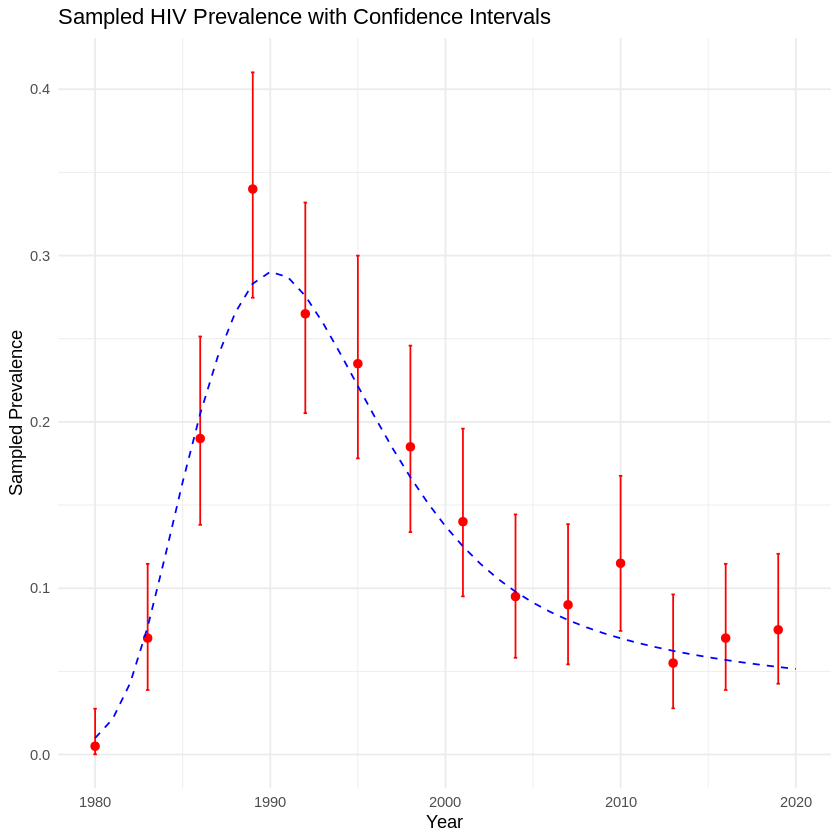

In [ ]:
# Sample the epidemic data
set.seed(1)
myDat <- sampleEpidemic(simDat)

# Plot sampled prevalence with confidence intervals
ggplot(myDat, aes(x = time, y = sampPrev)) +
  geom_point(color = "red", size = 2) +
  geom_errorbar(aes(ymin = lci, ymax = uci), width = 0.2, color = "red") +
  labs(title = "Sampled HIV Prevalence with Confidence Intervals",
       x = "Year",
       y = "Sampled Prevalence") +
  theme_minimal() +
  geom_line(data = simDat, aes(x = time, y = P), color = "blue", linetype = "dashed")

Let's  calculate the negative log-likelihood of observing the sampled epidemic data (obsDat) given a set of parameters (parms) for the epidemic model.

In [ ]:
# Negative log-likelihood function
nllikelihood <- function(parms = disease_params(), obsDat = myDat) {
  simDat <- simEpidemic(init, tseq = tseqAnnual, modFunction = SImod, parms = parms)
  matchedTimes <- simDat$time %in% obsDat$time
  nlls <- -dbinom(obsDat$numPos, obsDat$numSamp, prob = simDat$P[matchedTimes], log = TRUE)
  return(sum(nlls))
}

The function given above computes the negative log-likelihood, which is a measure of how well the simulated epidemic data (simDat) matches the observed data (myDat) given the model parameters (parms).

In [ ]:
# Calculate log-likelihood for true parameters
nllikelihood(trueParms)

[1] 39.60161

In [ ]:
# Calculate log-likelihood for some random guessed parameters
nllikelihood(disease_params(lambda = 0.1, a = 0.05))

[1] 1293.467

Lower values of NLL indicate a better fit of the model to the observed data, as the likelihood of observing the data given the model parameters is higher.  Let's use optimization techniques (e.g., maximum likelihood estimation) to find parameters (parms) that minimize the NLL, indicating the best-fit model to the observed data.

Firstly, let's convert the fitted parameters (fit.params) back into their original scale from a logarithmic scale.

In [ ]:
# Function to substitute parameters
subsParms <- function(fit.params, fixed.params = disease_params()) {
  within(fixed.params, {
    loggedParms <- names(fit.params)[grepl("log_", names(fit.params))]
    unloggedParms <- names(fit.params)[!grepl("log_", names(fit.params))]
    for (nm in unloggedParms) assign(nm, as.numeric(fit.params[nm]))
    for (nm in loggedParms) assign(gsub("log_", "", nm), exp(as.numeric(fit.params[nm])))
    rm(nm, loggedParms, unloggedParms)
  })
}

Secondly, let's defines the objective function for optimization (optim function). In fact, it's the negative log-likelihood (nllikelihood) using transformed parameters (parms) for comparing model predictions against observed data (obsDat).

In [ ]:
objFXN <- function(fit.params, fixed.params = disease_params(), obsDat = myDat) {
  parms <- subsParms(fit.params, fixed.params)
  nllikelihood(parms, obsDat = obsDat)
}

Thirdly, let's set an initial guesses for parameters in logarithmic scale.

In [ ]:
# Initial parameter guesses
init.pars <- c(log_lambda = log(0.5), log_a = log(3), log_cMax = log(0.65),
log_cRate = log(2), log_cHalf = log(2000), log_delta = log(0.02),
               log_b = log(0.03), log_mu = log(0.02))

  We are gonna use simulated annealing (method = "SANN") for initial optimization attempts.

In [ ]:
optim.vals <- optim(par = init.pars, objFXN, fixed.params = disease_params(),
obsDat = myDat, control = list(trace = 3, maxit = 150), method = "SANN")
exp(unname(optim.vals$par))

sann objective function values
initial       value 531.258599
final         value 91.871806
sann stopped after 149 iterations


[1] 7.779592e-01 1.031462e+01 4.059427e-01 3.717183e+00 2.001893e+03
[6] 9.749649e-02 1.658102e-03 1.711041e-02

Let's refines parameter estimates (optim.vals$par) using the `Nelder-Mead `optimization method.

In [ ]:
# Optimize using Nelder-Mead
optim.vals <- optim(par = optim.vals$par, objFXN, fixed.params = disease_params(),
obsDat = myDat, control = list(trace = 3, maxit = 800, reltol = 10^-7), method = "Nelder-Mead", hessian = TRUE)
optim.vals
#  Converts optimized parameters (MLEfits) from logarithmic scale to their original scale.
MLEfits <- optim.vals$par
final_parameters <- c(exp(unname(MLEfits)))

  Nelder-Mead direct search function minimizer
function value for initial parameters = 91.871806
  Scaled convergence tolerance is 9.18718e-06
Stepsize computed as 0.760185
BUILD              9 157.635236 71.808163
HI-REDUCTION      11 138.971060 71.808163
HI-REDUCTION      13 130.129213 71.808163
HI-REDUCTION      15 121.055265 71.808163
HI-REDUCTION      17 116.619029 71.808163
HI-REDUCTION      19 115.783196 71.808163
HI-REDUCTION      21 113.521572 71.808163
HI-REDUCTION      23 113.020349 71.808163
HI-REDUCTION      25 113.009430 71.808163
HI-REDUCTION      27 112.523984 71.808163
SHRINK            37 116.317062 71.808163
SHRINK            47 118.566678 71.214034
SHRINK            57 119.780931 69.468088
HI-REDUCTION      59 115.738272 69.468088
LO-REDUCTION      61 104.192940 63.982698
LO-REDUCTION      63 95.205697 63.677543
LO-REDUCTION      65 71.221484 62.422862
LO-REDUCTION      67 71.218678 62.422862
LO-REDUCTION      69 71.218640 62.422862
LO-REDUCTION      71 71.214034 62

,log_lambda,log_a,log_cMax,log_cRate,log_cHalf,log_delta,log_b,log_mu
log_lambda,6.401640e+02,-4.491074e+02,-1.338358e+03,-1.637441e-01,6.883840e+04,-5.600965e+02,-6.012270e+00,3.559090e-03
log_a,-4.491074e+02,3.479530e+02,9.735973e+02,1.308724e+00,-5.956389e+04,4.493119e+02,4.756651e+00,-2.861272e-03
log_cMax,-1.338358e+03,9.735973e+02,5.672411e+03,1.176059e+01,-1.168463e+05,1.893963e+03,1.711372e+01,-2.000615e-03
log_cRate,-1.637441e-01,1.308724e+00,1.176059e+01,7.348238e-01,-5.693738e+02,5.192759e+00,3.641382e-02,1.621085e-04
log_cHalf,6.883840e+04,-5.956389e+04,-1.168463e+05,-5.693738e+02,1.580258e+07,-7.011512e+04,-7.771744e+02,-4.712192e-03
log_delta,-5.600965e+02,4.493119e+02,1.893963e+03,5.192759e+00,-7.011512e+04,7.469624e+02,7.197451e+00,-1.311032e-03
log_b,-6.012270e+00,4.756651e+00,1.711372e+01,3.641382e-02,-7.771744e+02,7.197451e+00,-3.260704e-02,-1.257838e-05
log_mu,3.559090e-03,-2.861272e-03,-2.000615e-03,1.621085e-04,-4.712192e-03,-1.311032e-03,-1.257838e-05,-2.680611e-04


In [ ]:
# @title
# # L-BFGS-B (Limited-memory Broyden–Fletcher–Goldfarb–Shanno with Bounds):
# # Example of parameter bounds
# lower_bounds <- c(log_lambda = -Inf, log_a = -Inf, log_cMax = -Inf,
#                   log_cRate = -Inf, log_cHalf = 1000, log_delta = -Inf,
#                   log_b = -Inf, log_mu = -Inf)

# upper_bounds <- c(log_lambda = 0, log_a = 5, log_cMax = 1,
#                   log_cRate = 5, log_cHalf = 3000, log_delta = 0,
#                   log_b = 0.05, log_mu = 0.05)

# # Combine into a bounds matrix
# bounds <- rbind(lower_bounds, upper_bounds)


# # Perform optimization using L-BFGS-B
# optim.vals <- optim(par = init.pars, fn = objFXN, gr = NULL, fixed.params = disease_params(),
#                     obsDat = myDat, lower = bounds[1, ], upper = bounds[2, ], method = "L-BFGS-B")

# # Extract optimized parameters
# MLEfits <- optim.vals$par
# final_parameters <- exp(MLEfits)
# final_parameters

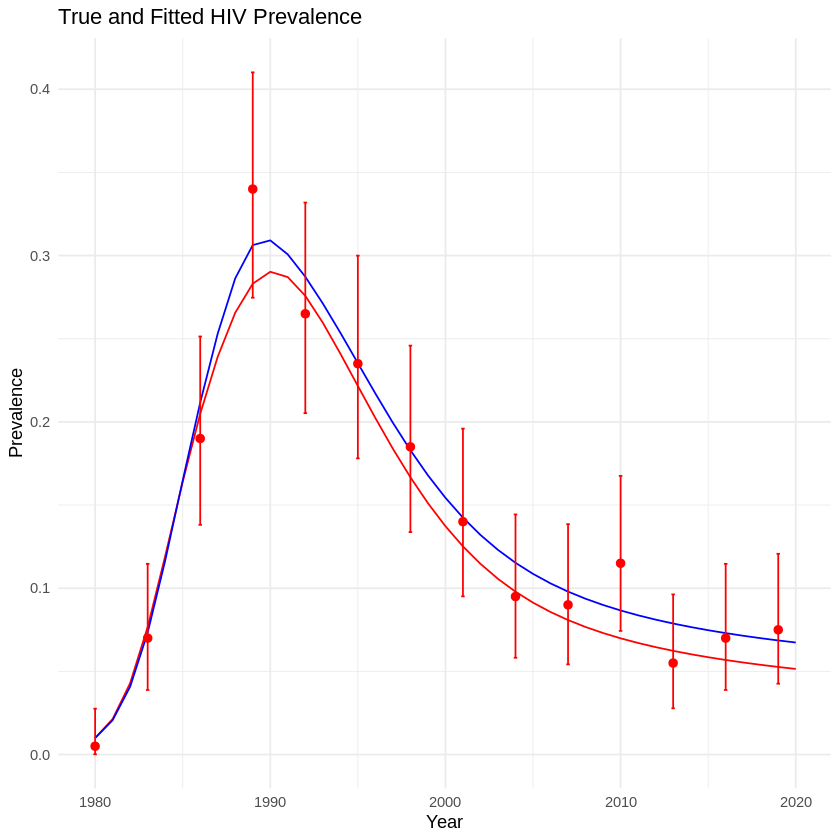

In [ ]:
# Plot MLE fit time series
fitDat <- simEpidemic(init, tseq = tseqAnnual, modFunction = SImod, parms = subsParms(optim.vals$par, trueParms))

ggplot() +
  geom_line(data = simDat, aes(x = time, y = P), color = "red") +
  geom_line(data = fitDat, aes(x = time, y = P), color = "blue") +
  geom_point(data = myDat, aes(x = time, y = sampPrev), color = "red", size = 2) +
  geom_errorbar(data = myDat, aes(x = time, ymin = lci, ymax = uci), width = 0.2, color = "red") +
  labs(title = "True and Fitted HIV Prevalence",
       x = "Year",
       y = "Prevalence") +
  theme_minimal()

# **Section 2 : Markov Chain Monte Carlo (MCMC)**